# CAO POINTS ANALYSIS
### AUTHOR: ANTE DUJIC
<hr style="border:2px solid black"> </hr>

## INTRODUCTION
<hr style="border:2px solid gray"> </hr>

This notebook gives an overview of how to load CAO points information from the CAO website into a pandas data frame. It also contains the comparison of CAO points in 2019, 2020, and 2021.

[<center><img src="http://www.cao.ie/images/cao.png" width="100"/></center> ](http://www.cao.ie/index.php)

***
### CONTENTS

1. [WHAT IS CAO](#CAO)
2. [LOADING AND SAVING THE DATA](#DATA)
    - 2.1. [LEVEL 8 POINTS - R1 and R2](#R1R2)
        - 2.1.1. [2019, 2020, 2021 (html)](#HTML)
    - 2.2. [LEVEL 8 POINTS - EOS and MID](#EOSMID)
        - 2.2.1. [2020 (xlsx)](#XLSX)
        - 2.2.2. [2019 (pdf)](#PDF)
2. [CONCATENATING THE DATA](#CONCATENATE)

## 1. WHAT IS CAO <a id='CAO'></a>
<hr style="border:2px solid gray"> </hr>

The purpose of the Central Applications Office (CAO) is to process centrally applications for undergraduate courses in Irish Higher Education Institutions (HEIs), and to deal with them in an efficient and fair manner. [1]

Students applying for admission to third level education courses in Ireland apply to the CAO rather than to individual educational institutions such as colleges and universities. The CAO then offers places to students who meet the minimum requirements for a course for which they have applied. If for a particular course there are more qualified applicants than available places, the CAO makes offers to those applicants with the highest score in the CAO points system. If students do not accepts offers, or later decline them because they receive an offer for another course, the CAO makes further offers until all of the places have been filled or until the offer season closes. [2]

## 2. LOADING AND SAVING THE DATA <a id='DATA'></a>
<hr style="border:2px solid gray"> </hr>

In [1]:
# HTTP request
import requests as rq
# Regular expressions
import re
# Dates and time
import datetime as dt
# Data frames
import pandas as pd
# For downloading
import urllib.request as urlrq
# PDF
import camelot
# To use .unescape
import html
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1.  LEVEL 8 POINTS - R1 and R2 <a id='R1R2'></a>
***

Overview

#### 2.1.1. 2019, 2020, 2021 (html) <a id='HTML'></a>

In [2]:
# Current date and time
now = dt.datetime.now()
# Format as a string
nowstr = (now.strftime("%Y%m%d_%H%M%S"))

In [3]:
# Regular expression
re_course = re.compile(r"([A-Z]{2}[0-9]{3})(.*)")

In [4]:
# Defining a dictionary
    # Using website archive to access the wanted data (2019, 2020)
years_dict = {
    "2019": [("data/cao2019" +  nowstr), "https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php"],
    "2020": [("data/cao2020" +  nowstr), "https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php"],
    "2021": [("data/cao2021" +  nowstr), "http://www2.cao.ie/points/l8.php"]
}

In [5]:
# Loop through the (dict) years
for year, content in years_dict.items():
    # Fetch the CAO points URL
    rq.get (content[1])
    resp = rq.get (content[1])
    # The server uses the wrong encoding
        # Change to "cp1252"
    resp.encoding = "cp1252"
    # Check if OK:
        #Response [200] means OK
    print (year,resp)
    
    # Save the original html file
    with open(content[0] + ".html", "w") as f:
        f.write(resp.text)
        # Keep track of how many courses we process
    
    no_lines = 0
    # Iterating through the lines
    resp.iter_lines()
    resps = resp.iter_lines()
    
    # Open the csv file for writing.
    with open(content[0] + ".csv", "w") as f:
        # Write a header row.
        f.write(','.join(["CODE", "TITLE", "R1_POINTS", "R2_POINTS"]) + "\n")
        # Loop through lines of the response.
        for line in resps:
            # Decode the line, using the wrong encoding
            dline = line.decode("cp1252")
            # Converting &amp; to &
            dline = html.unescape(dline)
            # Match only the lines representing courses
            if re_course.fullmatch(dline):
                # Add one to the lines counter
                no_lines = no_lines + 1
                # The course code
                course_code = dline[:5]
                # The course title
                course_title = dline[7:57]
                # Round one points
                course_points = re.split(' +', dline[60:])
                if len(course_points) != 2:
                    course_points = course_points[:2]
                # Join the fields using a comma
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                # Rejoin the substrings with commas in between
                f.write(",".join(linesplit) + "\n")   
    # Print the total number of processed lines
    print("Total number of lines in CAO", year, "database is", no_lines)

2019 <Response [200]>
Total number of lines in CAO 2019 database is 930
2020 <Response [200]>
Total number of lines in CAO 2020 database is 961
2021 <Response [200]>
Total number of lines in CAO 2021 database is 949


### 2.2.  LEVEL 8 POINTS - EOS and MID <a id='EOSMID'></a>
***

Overview

#### 2.2.1. 2020 (xlsx) <a id='XLSX'></a>

In [6]:
# Create a file path for the original data
path = ("data/cao2020_eos" +  nowstr + ".xlsx")

In [7]:
# Copying network xlsx file
urlrq.urlretrieve('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx', path)

('data/cao2020_eos20211123_185937.xlsx',
 <http.client.HTTPMessage at 0x26c9d9e71c0>)

In [8]:
# Download and parse the excel spreadsheet
df2020_eos = pd.read_excel("http://www2.cao.ie/points/CAOPointsCharts2020.xlsx", skiprows = 10)

In [9]:
# Filter out only level 8 courses
df2020_eos = df2020_eos.loc[df2020_eos["LEVEL"] == 8]
# Remove last 12 columns
df2020_eos = df2020_eos.iloc[: , :-12]
# Save pandas data frame to disk
df2020_eos.to_csv(("data/cao2020_eos" +  nowstr + ".csv"))
#df2020_eos

***

#### 2019 (pdf) <a id='PDF'></a>

In [10]:
# Creating a file path for the original data
path2019pdf = 'data/cao2019_eos' + nowstr + '.pdf'

In [11]:
# Fetch the CAO points URL
resp_pdf = rq.get("http://www2.cao.ie/points/lvl8_19.pdf")
resp_pdf # <Response [200]> means OK

<Response [200]>

In [12]:
# Save the original file
with open(path2019pdf, 'wb') as f:
    f.write(resp_pdf.content)

In [13]:
# Read the pdf file
tables = camelot.read_pdf(path2019pdf, pages = "all", flavor = "lattice")

In [14]:
# Check the total number of tables read
print ("Tables:", tables.n)

Tables: 18


In [15]:
# Create empty list
table_total = []
# Loop through all 18 tables
for x in range (0,18):
    df = tables[x].df
    # Append all 18 tables to table_total
    table_total.append(df)

# Concatenate all tables  
table = pd.concat(table_total)
# Remove old column names
table = table.iloc[1: , :]
# Name the columns
table.columns = ["CODE","TITLE", "EOS_2019", "MID_2019"]
# Sort table by "CODE" column
table.sort_values("CODE", inplace = True)
# Remove first 35 rows (name of the college)
table = table.iloc[35: , :]
# Save .csv file
table.to_csv("data/cao2019_eos" +  nowstr + ".csv", index = False)
#table

## 3. CONCATENATING THE DATA <a id='CONCATENATE'></a>
<hr style="border:2px solid gray"> </hr>

In [16]:
# Defining a dictionary
df_dict = {
    "2019": [("data/cao2019" +  nowstr)],
    "2019_eos": [("data/cao2019_eos" +  nowstr)],
    "2020": [("data/cao2020" +  nowstr)],
    "2020_eos": [("data/cao2020_eos" +  nowstr)],
    "2021": [("data/cao2021" +  nowstr)]
}

In [17]:
# Creating an empty list for adding dataframes
dataframe = []
# Loop - reading the csv files and appending to list
for year, path in df_dict.items():
    data = pd.read_csv ((path[0] + ".csv"), encoding='cp1252')
    dataframe.append (data)
# Conecating all dataframes into one
allcourses = pd.concat (dataframe)
# Filering out columns
allcourses = allcourses [["CODE", "TITLE"]]
# Remove duplicates created by conecating
allcourses.drop_duplicates(subset=["CODE"], inplace=True, ignore_index=False)
# Sort the table by "CODE" column
allcourses.sort_values("CODE", inplace = True)
#allcourses

In [18]:
#2019 df
dataframe[0].columns = ["CODE","TITLE", "R1_POINTS_2019", "R2_POINTS_2019"]
#2019_eos is #dataframe[1]
#2020 df
dataframe[2].columns = ["CODE","TITLE", "R1_POINTS_2020", "R2_POINTS_2020"]
#2020_eos df
dataframe[3] = dataframe[3][["COURSE CODE2","EOS", "EOS Mid-point"]]
dataframe[3].columns = ["CODE","EOS_2020", "MID_2020"]
#2021 df
dataframe[4].columns = ["CODE","TITLE", "R1_POINTS_2021", "R2_POINTS_2021"]

In [19]:
# Loop - set "CODE" column as index for all df
for i in dataframe:
    i.set_index("CODE", inplace=True)

In [20]:
allcourses.set_index("CODE", inplace=True)
allcourses = allcourses.join(dataframe[0][["R1_POINTS_2019", "R2_POINTS_2019"]])
#allcourses

In [21]:
allcourses = allcourses.join(dataframe[1][["EOS_2019", "MID_2019"]])
#allcourses

In [22]:
allcourses = allcourses.join(dataframe[2][["R1_POINTS_2020", "R2_POINTS_2020"]])
#allcourses

In [23]:
allcourses = allcourses.join(dataframe[3][["EOS_2020", "MID_2020"]])
#allcourses

In [24]:
allcourses = allcourses.join(dataframe[4][["R1_POINTS_2021", "R2_POINTS_2021"]])
#allcourses

In [25]:
#allcourses.sort_values("CODE", inplace = True)
allcourses.to_csv ("Final_table.csv")
allcourses

,TITLE,R1_POINTS_2019,R2_POINTS_2019,EOS_2019,MID_2019,R1_POINTS_2020,R2_POINTS_2020,EOS_2020,MID_2020,R1_POINTS_2021,R2_POINTS_2021
CODE,,,,,,,,,,,
AC120,International Business ...,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts ...,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry) ...,#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design ...,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objec...,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD212,Recreation and Sport Management ...,274,NaN,274,311.0,270,NaN,270,349,262,NaN
WD230,Mechanical and Manufacturing Engineering ...,273,NaN,273,348.0,253,NaN,253,369,230,230
WD231,Early Childhood Care and Education ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266,NaN


## TESTING

In [26]:
df = pd.read_csv ("Final_table.csv")
# 2019
r1_2019 = df ["R1_POINTS_2019"]
r2_2019 = df ["R2_POINTS_2019"]
eos_2019 = df ["EOS_2019"]
mid_2019 = df ["MID_2019"]
# 2020
r1_2020 = df ["R1_POINTS_2020"]
r2_2020 = df ["R2_POINTS_2020"]
eos_2020 = df ["EOS_2020"]
mid_2020 = df ["MID_2020"]
# 2021
r1_2021 = df ["R1_POINTS_2021"]
r2_2021 = df ["R2_POINTS_2021"]

In [27]:
eos_2019 = eos_2019.str.replace(r'\D', '', regex=True)
eos_2019

0       234
1       252
2       550
3       635
4       545
       ... 
1142    274
1143    273
1144    NaN
1145    NaN
1146    NaN
Name: EOS_2019, Length: 1147, dtype: object

In [28]:
r1_2019 = r1_2019.str.replace(r'\D', '', regex=True)
r1_2019 = pd.to_numeric(r1_2019,errors='coerce')
r1_2020 = r1_2020.str.replace(r'\D', '', regex=True)
r1_2020 = pd.to_numeric(r1_2020,errors='coerce')
r1_2021 = r1_2021.str.replace(r'\D', '', regex=True)
r1_2021 = pd.to_numeric(r1_2021,errors='coerce')

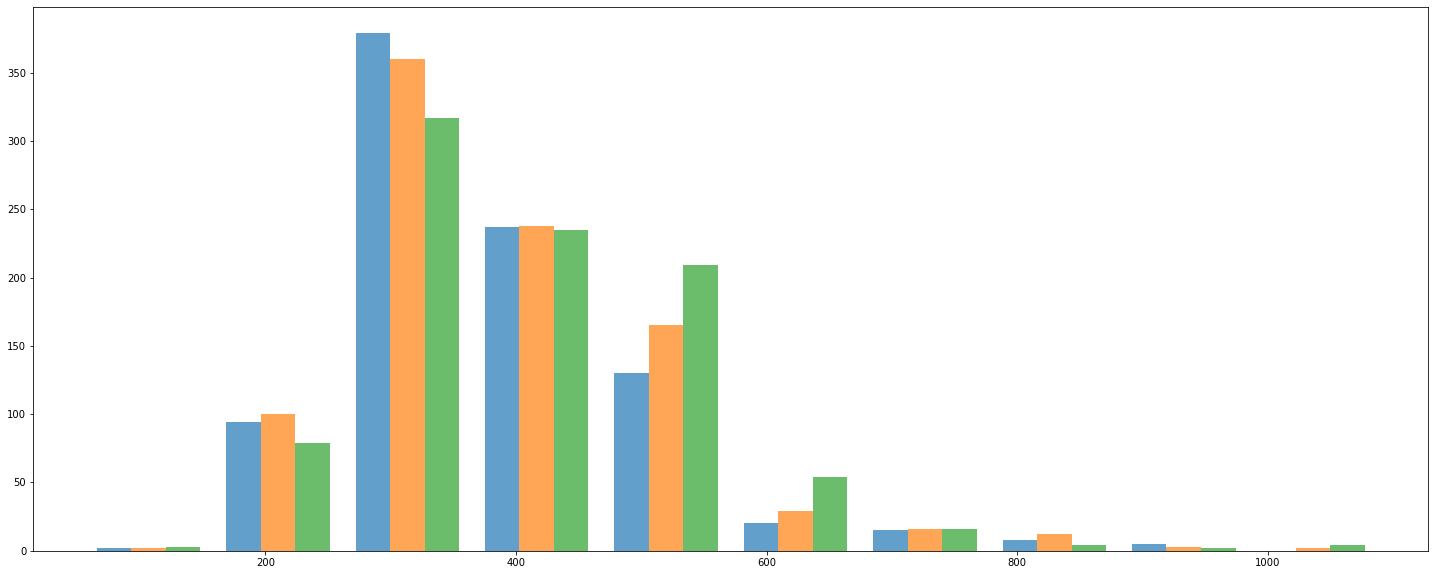

In [29]:
plt.rcParams['figure.figsize'] = [25, 10]
plt.hist ([r1_2019, r1_2020, r1_2021], alpha = 0.7)
plt.show()

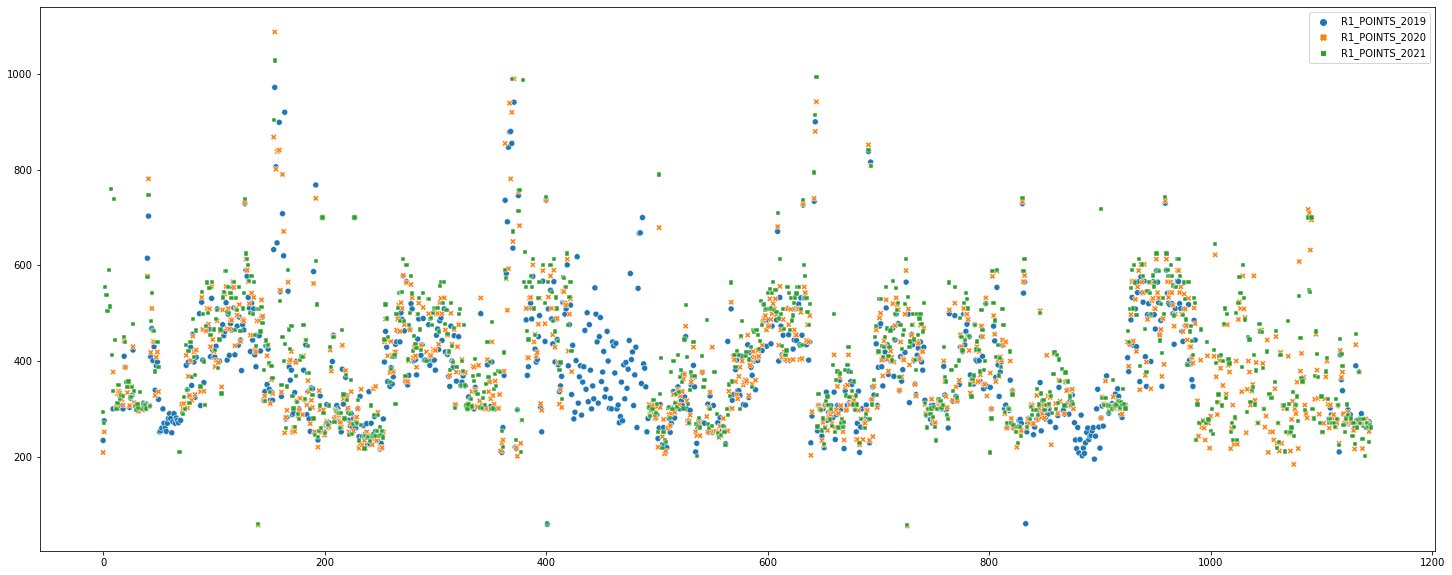

In [30]:
sns.scatterplot (data = [r1_2019, r1_2020, r1_2021])
plt.show()

In [31]:
r1_2019.describe()

count    890.000000
mean     380.137079
std      121.704187
min       59.000000
25%      297.250000
50%      352.000000
75%      442.750000
max      972.000000
Name: R1_POINTS_2019, dtype: float64

In [32]:
r1_2020.describe()

count     927.000000
mean      390.743258
std       128.482188
min        55.000000
25%       300.000000
50%       366.000000
75%       465.500000
max      1088.000000
Name: R1_POINTS_2020, dtype: float64

In [33]:
r1_2021.describe()

count     923.000000
mean      407.666306
std       128.706224
min        57.000000
25%       303.000000
50%       391.000000
75%       499.000000
max      1028.000000
Name: R1_POINTS_2021, dtype: float64

### DATA COMPARISON

# CONCLUSION

***

## REFERENCES
***

- [1] http://www2.cao.ie/handbook/handbook2022/hb.pdf
- [2] https://en.wikipedia.org/wiki/Central_Applications_Office

## LINKS TO CHECK